### This code post processes the experiment data of SD7003
    - just ensemble average, no filter

In [1]:
import numpy as np
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import csv

cm2in = 1/2.54           # conversion of in to cm
plt.rcParams.update({"font.size": 8})
plt.rcParams['lines.markersize'] ** 5 # set default marker size

Chord = 0.2              # chord length, m
Span = Chord*0.9         # airfoil surface area
dynP = (0.5*998*0.3**2)  # dynamic pressure

Color = ['#9d1939', '#0b1f38', '#eebd31', '#9d1939', '#0b1f38', '#eebd31']

def myCases(c):
    if c == 'A':
        Color = '#9d1939'
        Icon  = '.'
    if c == 'B':
        Color = '#0b1f38'
        Icon  = '.'
    if c == 'C':
        Color = '#eebd31' 
        Icon  = '.'
    if c == 'D':
        Color = '#9d1939'
        Icon  = '-'
    if c == 'E':
        Color = '#0b1f38'
        Icon  = '-'
    if c == 'F':
        Color = '#eebd31'
        Icon  = '-'
    
    return Icon,Color 


# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def reduceToOnePeriod(data,npoints):
    nPoints = np.size(data,axis=0)      # number of points in the original data-set
    nCycles = int(nPoints/npoints) # total number of cycles
    
    onePeriod = np.zeros(npoints)    # data that is 1-period long
    startp = 0
    endp   = npoints
    for n in range(nCycles):
        onePeriod = onePeriod + data[startp:endp]
        startp = startp + npoints
        endp   = startp + npoints
    
    onePeriod = onePeriod/nCycles  # mean of all the cycles

    return onePeriod

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

# Location of pressure ports:
xports = [0,0.04,0.08,0.12,0.16,0.2,0.24,0.28, 0.32, 0.36, 0.405, 0.5, 0.6, 0.7] # frequencies of the motion

# corrector factors for all sensors:
fix = [17000/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5, 2500/5] 

# Import coordinates of SD7003:
SD7003 = pd.read_csv('./inputs/reference/SD7003_coord.csv', skiprows=1, sep=',', usecols = [0,1]).to_numpy()
SD7003[:,1] = SD7003[:,1]*6
xs, ys = zip(*SD7003) #create lists of x and y values

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

print("\n==> This code run OK")


==> This code run OK


### plot force coefficients for steady case
Notice that:
- A negative moment coefficient indicates a nose-down moment which will reduce the angle of attack of the airfoil

CD:0.043
CL:0.857
CM:-0.016


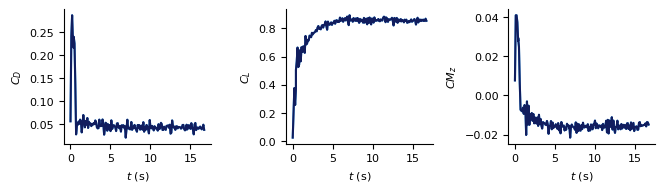

In [2]:
import pandas as pd
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

num_files  = 16     # number of force-coefs files
Alpha0 = 8

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Folder = './Inputs/Experiments/Steady/AoA' + str(Alpha0) + '/'
nt         = 170 # length of data
filterFreq = 0.5     # cut-off frequency for filter
dAlpha     = 0     # changes in AoA
RefFreq    = 0     # frequency of the motion

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

# Import data:
Data  = []   
for i in range(num_files):
    # import initial data
    fileName = 'Initial_Force_Data_Run_' + f'{i+1:02d}' + '.csv'
    idata = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=[2,4,7], nrows=9000).to_numpy() # transform data to numpy array
    idata = np.mean(idata,axis=0)

    # Import the force data:
    fileName = 'Force_Data_Run_' + f'{i+1:02d}' + '.csv'
    data = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=[0,2,4,7], names= ["id","fx","fy","mz"]) 
    
    # group data with the same time-stamps
    data = data.groupby("id",as_index=False).mean()
    time = data[["id"]].copy().to_numpy()/1000     # create time-vector: ms -> s
    data = data[["fx","fy","mz"]].copy().to_numpy() # transform data to numpy array

    # Calculate average of the solution:
    if i==0:
        Data = np.zeros((nt,3))
    else:
        Data = Data + data[0:nt,:] - idata
# calculate the mean force between experiments
Forces_ = Data/num_files # "fx","fy","mz"

# Fix force coefficient values based of the AoA:
AoA  = Alpha0*np.pi/180 # angle of attack, alpha = alpha(t)

Forces = np.zeros((nt,3)) 
for t in range(nt):
    c, s = np.cos(AoA), np.sin(AoA)
    R = np.array([[-c,s,0],[s,c,0],[0,0,1]])
    Forces[t,:] = R.dot(Forces_[t,:])
Forces[:,2]  = Forces_[:,2] # no need to transform mz

# now they are drag, lift, moment
Forces_[:,:] = Forces[:,:] # fix AoA in original data, Forces_, too.

# Calculate force coefficients: cd, cl, cm
forceCoefs_ = Forces_/(dynP*Span)
forceCoefs_[:,2] = forceCoefs_[:,2]/Chord

forceCoefs  = Forces/(dynP*Span)
forceCoefs[:,2] = forceCoefs[:,2]/Chord

# plot cd, cl, cm
names  = ['$C_D$', '$C_L$', '$CM_z$']
limits = [-0.2, 0.5, 0.0, 1.1, -0.1, 0.05]

axs = plt.figure(figsize=(17*cm2in, 5*cm2in)).subplots(1,3)
plt.rcParams['font.size'] = '8'

i = 0
j = 0
for ax in axs.flat:
    ax.plot(time[0:nt,:], forceCoefs_[:,i], '-', color='#3DB2FF' )
    ax.plot(time[0:nt,:], forceCoefs[:,i],  '-', color='#111D5E', label=names[i]  )
    ax.set(ylabel=names[i])
    #ax.set_ylim(limits[j], limits[j+1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.set_xlim([0, 6])
    #ax.legend(loc='best')
    ax.set(xlabel='$t$ (s)')
    i=i+1   
    j=j+2
plt.tight_layout()

# Calculate lift and drag coefficients:
CD_Mean = np.mean(forceCoefs[-50:-1,0])
CL_Mean = np.mean(forceCoefs[-50:-1,1])
CM_Mean = np.mean(forceCoefs[-50:-1,2])

#plt.show()
plt.savefig('./Outputs/ForceCoefess_Steady.png', bbox_inches='tight', dpi=450)

print("CD:" + f'{CD_Mean:0.3f}')
print("CL:" + f'{CL_Mean:0.3f}')
print("CM:" + f'{CM_Mean:0.3f}')

### Force coefficients vs AoA
Notice that:
 - A negative moment coefficient indicates a nose-down moment which will reduce the angle of attack of the airfoil

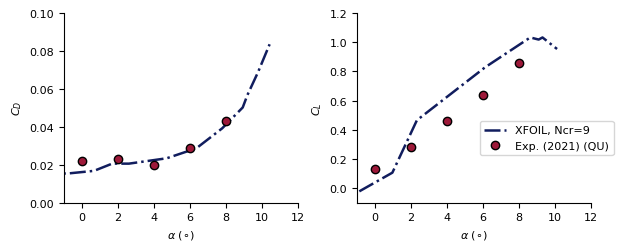

In [4]:
# Import experiments data:
data = pd.read_csv('./inputs/experiments/Steady/ForceCoeffs_vs_AoA.txt', skiprows=0, sep=',').to_numpy()

# Import reference data:
Folder = './inputs/reference/AirfoilDataBase_'
infile = ['CD','CL','CM'] # name of the ref-file we will open
limits = [0, 0.1, -0.1, 1.2, -0.06, 0.06]

axs    = plt.figure(figsize=(16*cm2in, 6.5*cm2in)).subplots(1,2)
names  = ['$C_D$', '$C_L$', '$CM_z$']
colors = ['darkorange','teal']

i = 0
j = 0
for ax in axs.flat:
      ax.xaxis.get_label().set_fontsize(8)
      ax.yaxis.get_label().set_fontsize(8)
      ax.spines['right'].set_visible(False)
      ax.spines['top'].set_visible(False)
      ax.set_ylabel(ylabel=names[i], fontsize = 8)
      ax.set_xlabel(r'$\alpha$ $(\circ)$', fontsize = 8)
      ax.set_xlim([-1, 12])
      ax.set_ylim(limits[j], limits[j+1])

      # Plot reference data:
      refFile = pd.read_csv(Folder+infile[i]+'_vs_AoA.csv', skiprows=1, sep=',').to_numpy()
      ax.plot(refFile[:,0], refFile[:,1], '-.', color='#111D5E', linewidth=1.8,label='XFOIL, Ncr=9' )

      # Plot experimental data data:
      ax.plot(data[:,0], data[:,i+1],'o', markerfacecolor='#9d1939', linewidth=1.8, markeredgecolor='#000000', label='Exp. (2021) (QU)' )

      i=i+1
      j=j+2

ax.legend(ncol=1 , loc='upper center', bbox_to_anchor=(0.81, 0.46))

plt.tight_layout()

plt.savefig('./outputs/ForceCoefess_vs_AoA.png', bbox_inches='tight', dpi=450)

**Plot force coefficients for dynamic cases**

Use the following parametes:
- Case 'A':
    - pitching
    - num_files: 16
    - RefFreq: 0.19
    - dAlpha:  4.5 
- Case 'B':
    - pitching
    - num_files: 16
    - RefFreq: 0.38
    - dAlpha:  4.5 
- Case 'C':
    - pitching
    - num_files: 10
    - RefFreq: 0.19
    - dAlpha:  6.0
- Case 'D':
    - plunging
    - num_files: 11
    - RefFreq: 0.19
    - dAlpha:  0  
- Case 'E':
    - plunging
    - num_files: 11
    - RefFreq: 0.38
    - dAlpha:  0 
- Case 'F':
    - plunging
    - num_files: 11
    - RefFreq: 0.19
    - dAlpha:  0 
    